## Загрузка библиотек

Здесь все как в [практике 2](https://colab.research.google.com/drive/1-0eknp0Qd4d2LxauhNwSZB4_Tb44UlJI?usp=share_link), но без подробностей.

In [1]:
import os
import pandas as pd
import warnings
import numpy as np

warnings.filterwarnings("ignore")

In [2]:
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
!echo '{"username":"nataliaafonina","key":"362b1fa4088ddc6937c685ff961b6ccf"}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
%%capture
!kaggle datasets download -d arashnic/book-recommendation-dataset
!unzip -q book-recommendation-dataset.zip

## Загрузка данных

Для колаборативной фильтрации нам понадобятся только айди пользователей, айди книжек и оценки, которые пользователи дали книжкам.

In [ ]:
ratings = pd.read_csv("Ratings.csv")
ratings.shape

(1149780, 3)

In [ ]:
users = pd.read_csv("Users.csv")
users.head(20)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
5,6,"santa monica, california, usa",61.0
6,7,"washington, dc, usa",NaN
7,8,"timmins, ontario, canada",NaN
8,9,"germantown, tennessee, usa",NaN
9,10,"albacete, wisconsin, spain",26.0


In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Приведем айди книжек в числовой вид.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(ratings["ISBN"].tolist())
ratings["ISBN"] = le.transform(ratings["ISBN"])
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,57188,0
1,276726,29750,5
2,276727,107392,0
3,276729,127253,3
4,276729,127287,6


In [ ]:
rating_non_zero = ratings[ratings["Book-Rating"] > 0]

In [ ]:
rating_non_zero.shape

(433671, 3)

## Рекоммендации с помощью pyspark

In [ ]:
ratings_spark = spark.createDataFrame(ratings)

In [ ]:
data_spark = (ratings_spark
    .select(
        'User-ID',
        'ISBN',
        'Book-Rating',
    )
).cache()

In [ ]:
(training, test) = data_spark.randomSplit([0.8, 0.2])

In [ ]:
als = ALS(maxIter=2, regParam=0.01,
          userCol="User-ID", itemCol="ISBN", ratingCol="Book-Rating",
          coldStartStrategy="drop",
          implicitPrefs=True)
model = als.fit(training)

predictions = model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="Book-Rating",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

evaluator = RegressionEvaluator(metricName="mae", labelCol="Book-Rating",
                                predictionCol="prediction")

mae = evaluator.evaluate(predictions)
print("MAE = " + str(mae))

Root-mean-square error = 4.666126064002115
MAE = 2.7026720491073943


In [ ]:
predictions.show()

+-------+----+-----------+-------------+
|User-ID|ISBN|Book-Rating|   prediction|
+-------+----+-----------+-------------+
| 181817|   0|          6|          0.0|
| 238557|  23|          0|          0.0|
|  11676|  38|          0|          0.0|
|  90148|  40|          0|          0.0|
|  13874|  44|         10| 3.3714547E-5|
| 218187|  61|          9|-1.5144024E-5|
| 275650|  61|          0|  3.988348E-6|
|  71285|  61|          0| 7.3098425E-5|
| 214319|  61|          0| 1.8910649E-6|
| 107899|  62|          0| 1.6261085E-5|
|  20859|  62|          0|          0.0|
| 120548|  64|          0| 0.0011038732|
|  71285|  64|          0|  8.719808E-5|
| 137348|  65|          7|          0.0|
|  85772|  66|          7|-3.8124304E-6|
| 236727|  74|          0|-2.2221604E-5|
| 268423|  91|          8|          0.0|
|  11776|  91|          8|          0.0|
|  11944| 121|          9| 0.0014549654|
|  23902| 123|          8| 0.0010884729|
+-------+----+-----------+-------------+
only showing top

In [ ]:
ratings_spark_0 = spark.createDataFrame(rating_non_zero)

In [ ]:
data_spark_0 = (ratings_spark_0
    .select(
        'User-ID',
        'ISBN',
        'Book-Rating',
    )
).cache()

In [ ]:
(training, test) = data_spark_0.randomSplit([0.8, 0.2])

In [ ]:
als = ALS(maxIter=2, regParam=0.01,
          userCol="User-ID", itemCol="ISBN", ratingCol="Book-Rating",
          coldStartStrategy="drop",
          implicitPrefs=True)
model = als.fit(training)

predictions = model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="Book-Rating",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

evaluator = RegressionEvaluator(metricName="mae", labelCol="Book-Rating",
                                predictionCol="prediction")

mae = evaluator.evaluate(predictions)
print("MAE = " + str(mae))

Root-mean-square error = 7.882783808104803
MAE = 7.673238748723926


## Рекоммендации с помощью surprise

In [ ]:
%%capture
!pip install scikit-surprise

In [ ]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

algo = SVD()
reader = Reader(rating_scale=(0, 11))
data = Dataset.load_from_df(ratings[["User-ID", "ISBN", "Book-Rating"]], reader)

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.5102  3.5028  3.5074  3.4939  3.4975  3.5024  0.0061  
MAE (testset)     2.8220  2.8152  2.8208  2.8104  2.8122  2.8161  0.0046  
Fit time          57.47   32.33   32.75   33.06   33.28   37.78   9.85    
Test time         3.42    2.57    2.17    3.67    3.72    3.11    0.63    


{'test_rmse': array([3.51021073, 3.50279986, 3.50740996, 3.49387398, 3.49748405]),
 'test_mae': array([2.82200399, 2.81519641, 2.82082834, 2.81037235, 2.81216706]),
 'fit_time': (57.47108197212219,
  32.33341956138611,
  32.74641156196594,
  33.05614137649536,
  33.28413367271423),
 'test_time': (3.41996169090271,
  2.569528102874756,
  2.1696736812591553,
  3.666555166244507,
  3.7232589721679688)}

Видим, что обе реализации справляются с задачей рекоммендации на этом датасете, но не слишком хорошо. Рейтинг изменяется в диапазоне от 0 до 10, а обе модели ошибаются примерно на 2.5. Однако SVD работает чуть стабильней относительно ALS.

## Задание на лабораторную работу 1

В примерах были рассмотрены два варианта рекомендаций посредством колаборативной фильтрации. В качестве практического задания вам предлагается использовать содержание датасетов, чтобы предсказывать, какую оценку пользователь поставит книге.

Для этого представим задачу предсказания оценки как задачу регрессии, где целевой переменной будет признак Book-Rating.
Тогда план анализа данных будет следующим:
1. Предобработать данные: преобразовать все категориальные данные в числовые (для преобразования названий книжек в вектор попробуйте 3 подхода: [bag-of-words](https://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage), [tf-idf](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting), [word2vec](https://radimrehurek.com/gensim/models/word2vec.html), обработать пустые ячейки и неточности в столбцах.
2. Сделать нормировку данных.
3. Обучить и протестировать не менее трех моделей регрессии. Например, [линейную регрессию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), [случайный лес](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) и [xgboost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html#training). Можно также попробовать применить нейронную сеть. Например, по этому [туториалу](https://www.tensorflow.org/tutorials/keras/regression).
4. Оценить результаты (RMSE, MAE).

In [4]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")
rating_non_zero = ratings[ratings["Book-Rating"] > 0]
books_ratings = pd.merge(
    books, rating_non_zero,
    left_on='ISBN',
    right_on='ISBN',
    how='inner'
)
books_ratings = books_ratings[['ISBN', 'Book-Title', 'User-ID', 'Book-Rating']]


In [5]:
books_ratings

,ISBN,Book-Title,User-ID,Book-Rating
0,0002005018,Clara Callan,8,5
1,0002005018,Clara Callan,11676,8
2,0002005018,Clara Callan,67544,8
3,0002005018,Clara Callan,116866,9
4,0002005018,Clara Callan,123629,9
...,...,...,...,...
383837,0395264707,Dreamsnake,275318,10
383838,1845170423,Cocktail Classics,275970,7
383839,0449906736,Flashpoints: Promise and Peril in a New World,276313,5
383840,0440400988,There's a Bat in Bunk Five,276463,7


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(books_ratings["ISBN"].tolist())
books_ratings["ISBN"] = le.transform(books_ratings["ISBN"])
books_ratings.head()

,ISBN,Book-Title,User-ID,Book-Rating
0,39,Clara Callan,8,5
1,39,Clara Callan,11676,8
2,39,Clara Callan,67544,8
3,39,Clara Callan,116866,9
4,39,Clara Callan,123629,9


In [7]:
books_ratings['Book-Title'] = books_ratings['Book-Title'].str.replace('\W', ' ', regex=True)

In [8]:
books_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383842 entries, 0 to 383841
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ISBN         383842 non-null  int64 
 1   Book-Title   383842 non-null  object
 2   User-ID      383842 non-null  int64 
 3   Book-Rating  383842 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 14.6+ MB


In [ ]:
books_ratings['Book-Rating'].describe()

count    383842.000000
mean          7.626701
std           1.841339
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: Book-Rating, dtype: float64

In [ ]:
books_ratings.duplicated().any()

False

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

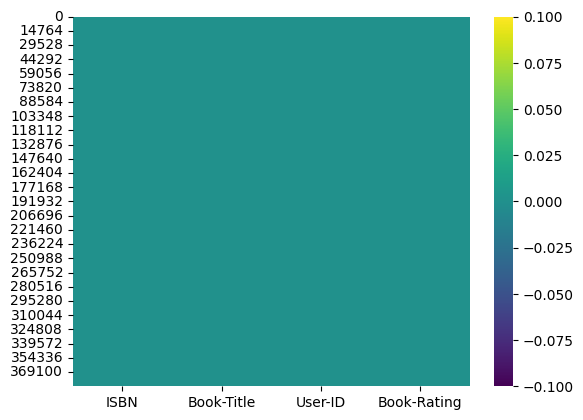

In [ ]:
sns.heatmap(books_ratings.isnull(), cmap='viridis')

Нет повторяющихся или пустых значений.

Text(0, 0.5, 'Frequency')

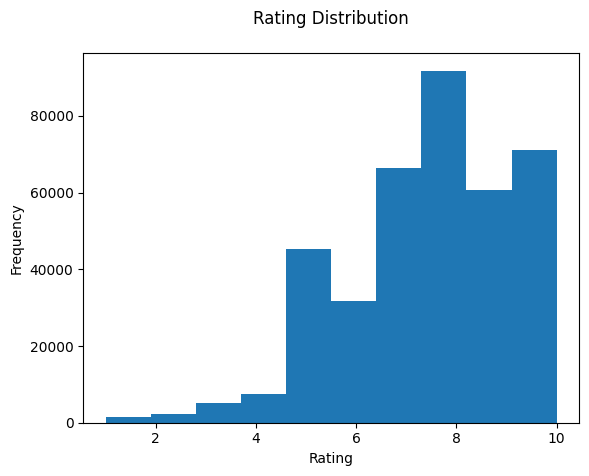

In [ ]:
plt.hist(books_ratings['Book-Rating'])
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Frequency')

In [9]:
users = pd.read_csv("Users.csv", encoding="utf-8")
users

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [ ]:
users.duplicated().any()

False

In [ ]:
users['Age'].isna().sum()

110762

In [10]:
data = pd.merge(books_ratings, users, on='User-ID', how='left')

In [11]:
data

,ISBN,Book-Title,User-ID,Book-Rating,Location,Age
0,39,Clara Callan,8,5,"timmins, ontario, canada",NaN
1,39,Clara Callan,11676,8,"n/a, n/a, n/a",NaN
2,39,Clara Callan,67544,8,"toronto, ontario, canada",30.0
3,39,Clara Callan,116866,9,"ottawa, ,",NaN
4,39,Clara Callan,123629,9,"kingston, ontario, canada",NaN
...,...,...,...,...,...,...
383837,41460,Dreamsnake,275318,10,"klamath falls, oregon, usa",49.0
383838,129765,Cocktail Classics,275970,7,"pittsburgh, pennsylvania, usa",46.0
383839,53784,Flashpoints Promise and Peril in a New World,276313,5,"livermore, california, usa",36.0
383840,48133,There s a Bat in Bunk Five,276463,7,"providence, rhode island, usa",26.0


In [14]:
data = data.dropna(subset=['Age'])

In [20]:
data['Age'] = data['Age'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269621 entries, 2 to 383841
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ISBN         269621 non-null  int64 
 1   Book-Title   269621 non-null  object
 2   User-ID      269621 non-null  int64 
 3   Book-Rating  269621 non-null  int64 
 4   Location     269621 non-null  object
 5   Age          269621 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.4+ MB


In [21]:
data

,ISBN,Book-Title,User-ID,Book-Rating,Location,Age
2,39,Clara Callan,67544,8,"toronto, ontario, canada",30
7,39,Clara Callan,219008,7,"halifax, nova scotia, canada",60
8,39,Clara Callan,263325,6,"fredericton, new brunswick, canada",27
9,4678,Decision in Normandy,2954,8,"wichita, kansas, usa",71
10,4678,Decision in Normandy,152827,7,"ottawa, ontario, canada",40
...,...,...,...,...,...,...
383837,41460,Dreamsnake,275318,10,"klamath falls, oregon, usa",49
383838,129765,Cocktail Classics,275970,7,"pittsburgh, pennsylvania, usa",46
383839,53784,Flashpoints Promise and Peril in a New World,276313,5,"livermore, california, usa",36
383840,48133,There s a Bat in Bunk Five,276463,7,"providence, rhode island, usa",26


# preprocessing

Необходимо преобразовать все категориальные данные в числовые. Для начала необходимо токенизировать.

In [22]:
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords

In [17]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
def preprocess_text(text):
    tokenized = nltk.word_tokenize(text)  # Токенизация
    punct = string.punctuation + "—" + "«" + "»"  # Пунктуация
    tokens = [token.lower() for token in tokenized if token not in punct]  # Удаление пунктуации и приведение к нижнему регистру
    stopwords_list = stopwords.words("english") + ["n/a"]  # Список стоп-слов для английского языка
    tokens = [word for word in tokens if word not in stopwords_list]  # Удаление стоп-слов
    return tokens

data['Processed-Book-Title'] = data['Book-Title'].apply(preprocess_text)
data['Processed-Location'] = data['Location'].apply(preprocess_text)


In [24]:
data['Processed-Book-Title'] = data['Processed-Book-Title'].apply(lambda tokens: ' '.join(tokens))
data['Processed-Location'] = data['Processed-Location'].apply(lambda tokens: ' '.join(tokens))

In [25]:
data.head()

,ISBN,Book-Title,User-ID,Book-Rating,Location,Age,Processed-Book-Title,Processed-Location
2,39,Clara Callan,67544,8,"toronto, ontario, canada",30,clara callan,toronto ontario canada
7,39,Clara Callan,219008,7,"halifax, nova scotia, canada",60,clara callan,halifax nova scotia canada
8,39,Clara Callan,263325,6,"fredericton, new brunswick, canada",27,clara callan,fredericton new brunswick canada
9,4678,Decision in Normandy,2954,8,"wichita, kansas, usa",71,decision normandy,wichita kansas usa
10,4678,Decision in Normandy,152827,7,"ottawa, ontario, canada",40,decision normandy,ottawa ontario canada


In [26]:
import random
random.seed(42)
data.sample(n=5)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Age,Processed-Book-Title,Processed-Location
325357,143492,Geschichten aus der LÃ Â wengrube Acht ErzÃ Â...,188411,9,"kleve, nordrhein-westfalen, germany",33,geschichten aus der lã â wengrube acht erzã â ...,kleve nordrhein-westfalen germany
114016,51505,Pop Goes the Weasel,147900,8,"pocomoke city, maryland, usa",32,pop goes weasel,pocomoke city maryland usa
356778,7691,Storyman,225172,6,"toormina, new south wales, australia",56,storyman,toormina new south wales australia
347097,147540,Poesia Completa,182429,9,"valencia, país valencià, spain",29,poesia completa,valencia país valencià spain
97785,118057,The Amateur Marriage A Novel,63854,7,"waterloo, ontario, canada",45,amateur marriage novel,waterloo ontario canada


# bag-of-words

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from scipy.sparse import hstack

In [29]:
title_vectorizer = CountVectorizer(binary=True)
X_text = title_vectorizer.fit_transform(data['Processed-Book-Title'])

location_vectorizer = CountVectorizer(binary=True)
X_location = location_vectorizer.fit_transform(data['Processed-Location'])

user_id_feature = data['User-ID'].values.reshape(-1, 1)

age_feature = data['Age'].values.reshape(-1, 1)

# Соединение векторов в один вектор
X = hstack([X_text, X_location, user_id_feature, age_feature])

In [30]:
from scipy.sparse import hstack

X = X
y = data['Book-Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Линейная регрессия

До учета возраста

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_linreg = model.predict(X_test)

mse_linreg = mean_squared_error(y_test, y_pred_linreg)
rmse_linreg = np.sqrt(mse_linreg)
mae_linreg = mean_absolute_error(y_test, y_pred_linreg)

print(f"MSE: {mse_linreg}")
print(f"RMSE: {rmse_linreg}")
print(f"MAE: {mae_linreg}")

MSE: 3.3762262111032095
RMSE: 1.8374510091709138
MAE: 1.4914616501221203


После

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_linreg = model.predict(X_test)

mse_linreg = mean_squared_error(y_test, y_pred_linreg)
rmse_linreg = np.sqrt(mse_linreg)
mae_linreg = mean_absolute_error(y_test, y_pred_linreg)

print(f"MSE: {mse_linreg}")
print(f"RMSE: {rmse_linreg}")
print(f"MAE: {mae_linreg}")

MSE: 3.266593775344708
RMSE: 1.80737206334078
MAE: 1.4522046739517376


In [32]:
y_pred_all_linreg = model.predict(X)

data_linreg = data.copy()
data_linreg['Predicted-Book-Rating'] = y_pred_all_linreg
data_linreg = data_linreg.drop(['Processed-Book-Title', 'Processed-Location'], axis=1)

In [33]:
random.seed(42)
data_linreg.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Age,Predicted-Book-Rating
113852,71566,The Best American Mystery Stories 2001,132282,7,"birmingham, alabama, usa",23,7.701983
353136,67695,Coffee Break Meditations 260 Devotions for th...,76482,5,"zanesville, ohio, usa",103,7.934711
35882,21065,Gettin Merry,216012,8,"clevelad, ohio, usa",34,7.700403
293641,75596,Mark Kistler S Draw Squad,198621,10,"melbourne, florida, usa",42,7.728022
184871,73645,Salem s Lot,67324,7,"bremerton, washington, usa",51,7.800112
378881,25582,Dinosaur Brains Dealing With All Those Imposs...,171118,6,"toronto, ontario, canada",47,7.751000
169187,140790,Die Geisha,12835,8,"hamburg, hamburg, germany",38,7.785319
17227,38819,The Da Vinci Code,62015,9,"springfield, illinois, usa",40,7.772882
241116,135839,ScÃ Â nario catastrophe,33145,8,"saint-dizier, champagne-ardenne, france",30,7.756705
34077,20641,The Climb Tragic Ambitions on Everest,191188,8,"oakland, california, usa",80,7.831550


До

In [ ]:
title_counts = data_linreg['Book-Title'].value_counts()

most_common_title = title_counts.idxmax()

result = data_linreg[data_linreg['Book-Title'] == most_common_title]
result.head()

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
9807,21945,The Lovely Bones A Novel,277439,7,"turner, oregon, usa",7.578295
9808,21945,The Lovely Bones A Novel,277752,7,"baton rouge, louisiana, usa",7.578189
9809,21945,The Lovely Bones A Novel,278633,9,"sandy, utah, usa",7.577892
9810,21945,The Lovely Bones A Novel,638,10,"san diego, california, usa",7.671604
9811,21945,The Lovely Bones A Novel,709,3,"roanoke, virginia, usa",7.671580


После

In [34]:
title_counts = data_linreg['Book-Title'].value_counts()

most_common_title = title_counts.idxmax()

result = data_linreg[data_linreg['Book-Title'] == most_common_title]
result.head()

,ISBN,Book-Title,User-ID,Book-Rating,Location,Age,Predicted-Book-Rating
9807,21945,The Lovely Bones A Novel,277439,7,"turner, oregon, usa",65,7.760049
9808,21945,The Lovely Bones A Novel,277752,7,"baton rouge, louisiana, usa",18,7.635247
9810,21945,The Lovely Bones A Novel,638,10,"san diego, california, usa",20,7.742420
9811,21945,The Lovely Bones A Novel,709,3,"roanoke, virginia, usa",14,7.726474
9812,21945,The Lovely Bones A Novel,1075,7,"hurst, texas, usa",49,7.819161


До

In [ ]:
data_linreg.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Predicted-Book-Rating
0,39,Clara Callan,8,5,"timmins, ontario, canada",7.671816
1,39,Clara Callan,11676,8,"n/a, n/a, n/a",7.667883
2,39,Clara Callan,67544,8,"toronto, ontario, canada",7.649050
3,39,Clara Callan,116866,9,"ottawa, ,",7.632424
4,39,Clara Callan,123629,9,"kingston, ontario, canada",7.630144


После

In [35]:
data_linreg.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Age,Predicted-Book-Rating
2,39,Clara Callan,67544,8,"toronto, ontario, canada",30,7.743972
7,39,Clara Callan,219008,7,"halifax, nova scotia, canada",60,7.767936
8,39,Clara Callan,263325,6,"fredericton, new brunswick, canada",27,7.664093
9,4678,Decision in Normandy,2954,8,"wichita, kansas, usa",71,7.876799
10,4678,Decision in Normandy,152827,7,"ottawa, ontario, canada",40,7.739193


# word2vec

In [36]:
data['Processed-Book-Title'].unique()

array(['clara callan', 'decision normandy',
       'flu story great influenza pandemic 1918 search virus caused', ...,
       'cocktail classics', 'flashpoints promise peril new world',
       'one one hundred'], dtype=object)

In [37]:
import urllib.request # библиотека для скачивания данных
import gensim # библиотека для загрузки и использвоания моделй w2v
from gensim.models import word2vec # непосредственно методы w2v
from gensim.models import Word2Vec

In [38]:
# Функция для создания векторов Word2Vec
def create_word2vec_vectors(column):
    preprocessed_corpus = column.astype(str).apply(lambda text: text.split())
    model = Word2Vec(sentences=preprocessed_corpus, vector_size=100, window=5, min_count=1, workers=4)
    vectors = column.apply(lambda row: np.mean([model.wv[word] for word in str(row).split() if word in model.wv], axis=0))
    return np.vstack(vectors)

In [62]:
age_column = data['Age']
user_column = data['User-ID']

# Создание векторов для каждого столбца
age_vectors = StandardScaler().fit_transform(age_column.values.reshape(-1, 1))
user_vectors = StandardScaler().fit_transform(user_column.values.reshape(-1, 1))
title_vectors = create_word2vec_vectors(data['Book-Title'])
location_vectors = create_word2vec_vectors(data['Location'])


In [63]:
# Проверка длины векторов
def check_vector_lengths(*vectors):
    lengths = [vector.shape[1] for vector in vectors]
    unique_lengths = set(lengths)
    if len(unique_lengths) == 1:
        print("Все векторы имеют одинаковую длину.")
    else:
        print("Длины векторов различны.")

In [66]:
# Проверка длины векторов
check_vector_lengths(user_vectors, age_vectors, title_vectors, location_vectors)

Длины векторов различны.


In [67]:
# Объединение векторов
combined_vectors = np.column_stack((user_vectors, age_vectors, title_vectors, location_vectors))

In [68]:
data['Combined_Vector_Column'] = combined_vectors.tolist()
data

,ISBN,Book-Title,User-ID,Book-Rating,Location,Age,Processed-Book-Title,Processed-Location,Combined_Vector_Column
2,39,Clara Callan,67544,8,"toronto, ontario, canada",30,clara callan,toronto ontario canada,"[-0.896362921685662, -0.4970420356736271, 0.01..."
7,39,Clara Callan,219008,7,"halifax, nova scotia, canada",60,clara callan,halifax nova scotia canada,"[1.0233159683655366, 1.6842971232306496, 0.016..."
8,39,Clara Callan,263325,6,"fredericton, new brunswick, canada",27,clara callan,fredericton new brunswick canada,"[1.5849966936230167, -0.7151759515640548, 0.01..."
9,4678,Decision in Normandy,2954,8,"wichita, kansas, usa",71,decision normandy,wichita kansas usa,"[-1.7149868818901126, 2.484121481495551, 0.070..."
10,4678,Decision in Normandy,152827,7,"ottawa, ontario, canada",40,decision normandy,ottawa ontario canada,"[0.1845274204434008, 0.23007101729446514, 0.07..."
...,...,...,...,...,...,...,...,...,...
383837,41460,Dreamsnake,275318,10,"klamath falls, oregon, usa",49,dreamsnake,klamath falls oregon usa,"[1.7369978881536248, 0.8844727649657481, -0.00..."
383838,129765,Cocktail Classics,275970,7,"pittsburgh, pennsylvania, usa",46,cocktail classics,pittsburgh pennsylvania usa,"[1.7452614401284399, 0.6663388490753205, 0.034..."
383839,53784,Flashpoints Promise and Peril in a New World,276313,5,"livermore, california, usa",36,flashpoints promise peril new world,livermore california usa,"[1.749608676826847, -0.060774203892771744, 0.3..."
383840,48133,There s a Bat in Bunk Five,276463,7,"providence, rhode island, usa",26,bat bunk five,providence rhode island usa,"[1.7515098007474335, -0.7878872568608639, -0.5..."


In [69]:
# Проверка длин векторов еще раз
vector_lengths = data['Combined_Vector_Column'].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else 0)
unique_lengths = vector_lengths.nunique()

if unique_lengths == 1:
    print("Все векторы имеют одинаковую длину.")
else:
    print("Длины векторов различны.")

Все векторы имеют одинаковую длину.




> Линейная регрессия



In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

In [70]:
X = combined_vectors
y = data['Book-Rating']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
# Масштабирование признаков (стандартизация)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [72]:
# Инициализация модели линейной регрессии
model = LinearRegression()

# Обучение модели
model.fit(X_train_scaled, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test_scaled)

# Оценка качества модели
mse_w2v = mean_squared_error(y_test, y_pred)
rmse_w2v = np.sqrt(mse_w2v)
mae_w2v = mean_absolute_error(y_test, y_pred)
print("MSE:", mse_w2v)
print("RMSE:", rmse_w2v)
print("MAE:", mae_w2v)

MSE: 3.158497613108582
RMSE: 1.7772162538950014
MAE: 1.4169711170286587


In [73]:
y_pred_all_linreg = model.predict(X)

data_w2v_linreg = data.copy()
data_w2v_linreg['Predicted-Book-Rating'] = y_pred_all_linreg
data_w2v_linreg = data_w2v_linreg.drop(['Processed-Book-Title', 'Combined_Vector_Column', 'Processed-Location'], axis=1)

In [51]:
import random

In [74]:
random.seed(42)
data_w2v_linreg.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Age,Predicted-Book-Rating
251045,119922,Endangered Species,36609,5,"zachary, louisiana, usa",32,7.606189
117287,144307,Der Kleine Prinz Prince German Hardy Boys,228171,8,"münchen / munich, bayern, germany",27,7.503763
30515,72906,We ll Meet Again,59548,8,"danville, california, usa",64,7.754929
300456,49682,Splendid Torment,88677,8,"laval, quebec, canada",44,8.210627
354721,103631,Classic Italian Cuisine Classic Cuisine Series,187763,5,"nyack, new york, usa",33,7.915711
374113,149529,Miracles through pranic healing,224366,9,"kuala lumpur, kuala lumpur, malaysia",33,7.494686
176756,54315,Nuts,187801,5,"barcelona, catalunya, spain",47,7.068298
157404,20939,Winter Solstice,146468,10,"lumberton, north carolina, usa",56,7.751125
366189,126019,Collector s Encyclopedia of Barbie Doll Exclus...,240528,10,"aptos, california, usa",46,7.943037
262196,68157,Barry Trotter and the Unnecessary Sequel,164705,7,"crawley, england, united kingdom",25,7.796932


In [75]:
title_counts = data_w2v_linreg['Book-Title'].value_counts()

most_common_title = title_counts.idxmax()

result = data_w2v_linreg[data_w2v_linreg['Book-Title'] == most_common_title]
result.head()

,ISBN,Book-Title,User-ID,Book-Rating,Location,Age,Predicted-Book-Rating
9807,21945,The Lovely Bones A Novel,277439,7,"turner, oregon, usa",65,7.734071
9808,21945,The Lovely Bones A Novel,277752,7,"baton rouge, louisiana, usa",18,7.689557
9810,21945,The Lovely Bones A Novel,638,10,"san diego, california, usa",20,7.865174
9811,21945,The Lovely Bones A Novel,709,3,"roanoke, virginia, usa",14,7.817203
9812,21945,The Lovely Bones A Novel,1075,7,"hurst, texas, usa",49,7.973926




> xgboost


In [76]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"MSE: {mse_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"MAE: {mae_xgb}")

MSE: 2.87953364076209
RMSE: 1.696918866876696
MAE: 1.3416677317886812


In [77]:
y_pred_all_xgb = xgb_model.predict(X)
data_xgb = data.copy()
data_xgb['Predicted-Book-Rating'] = y_pred_all_xgb
data_xgb = data_xgb.drop(['Processed-Book-Title', 'Processed-Location', 'Combined_Vector_Column'], axis=1)

In [78]:
random.seed(42)
data_xgb.sample(n=10)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Age,Predicted-Book-Rating
226974,36127,Mail Order Bride Avon Romance,212965,7,"akron,, ohio, usa",43,7.667652
58953,47318,The Client,14387,5,"coalville, leicestershire, england, united kin...",35,7.782060
296605,113603,The New Farm Vegetarian Cookbook,115003,10,"asheville, north carolina, usa",43,8.000393
363408,63137,Saints Rest,164675,7,"portland, oregon, usa",55,8.191114
103983,66758,The Last Suppers,226702,5,"allen, texas, usa",55,7.893268
281901,138726,Mord ist aller Laster Anfang Ein Mitchell und...,90481,8,"bremen, bremen, germany",48,7.777534
269362,32994,Welcome to Paradise A Novel,264311,5,"atlantic highlands, new jersey, usa",29,7.847046
106570,24596,Off for the Sweet Hereafter,184401,7,"olympia, washington, united state",55,7.715250
204896,93884,The Wish List,23547,10,"mcallen, texas, usa",26,7.956846
284328,40111,The Burn A Novel in Three Books Late Sixties...,261402,5,"minneapolis, minnesota, usa",38,7.904011


In [80]:
data_xgb.head(5)

,ISBN,Book-Title,User-ID,Book-Rating,Location,Age,Predicted-Book-Rating
2,39,Clara Callan,67544,8,"toronto, ontario, canada",30,7.773178
7,39,Clara Callan,219008,7,"halifax, nova scotia, canada",60,7.623041
8,39,Clara Callan,263325,6,"fredericton, new brunswick, canada",27,7.730577
9,4678,Decision in Normandy,2954,8,"wichita, kansas, usa",71,8.111403
10,4678,Decision in Normandy,152827,7,"ottawa, ontario, canada",40,7.757004


In [82]:
data_xgb.to_csv('data_w2v_xgb_age.csv', index=False)